In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 

# from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"



# from IPython.display import HTML

# a lib for network generation and other operations
import networkx as nx

# import random
import time

from mesa.space import MultiGrid
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector



# import cvxpy as cp

In [2]:
# the Simulation classes including vehicles and the environment

  

class BlueVehicle(Agent):
    
    def __init__(self, unique_id, model):
        # based on super class Agent provided by mesa initialse   
        super().__init__(unique_id, model)
        
        
        # initialise the radio power based on what the simulation (model) has
        self.power = model.radio_power_all[unique_id]
        
        # this is the proposed power to potentially cut neighbours and reduce sig
        self.proposed_power = self.power
        
        # this is the proposed location to reduce sig
        self.proposed_position = self.model.pos_blue[self.unique_id]
        
        
#         # the list of enemy locations is the same for each blue vehicle (for now)
#         self.l_e_list = np.array([np.array(x) for x in self.model.pos_red.values()])
        
        
#         # position of own vehicle
#         self.l_i = self.model.pos_blue[unique_id]
        
#         # the list of all successor blue vehicle locations 
#         self.successors = self.model.successors(unique_id)
        
        # The leading state of agent 1 for having the most contribution to enemy signature 0 otherwise, initialized to leader unless proven otherwise
        self.lead = 1
        
        # the agent who will get a link leading to it, deleted in the network
        self.lose = 0
        
        # This flag captures if agent has been a leader before but has failed to cut
        self.fail = 0
        
        # max signature in the network will be initialized with own signature in before and after cut cases
        self.max_sig_b = np.max([self.power/(np.linalg.norm(self.model.pos_blue[self.unique_id]-
                                                            self.model.pos_red[i])**2)
                                 for i in range(len(self.model.pos_red))])
        self.max_sig_a = self.max_sig_b 
        
        
        
        # counter to indicate the end of leader selection
        self.leader_counter = 0
        

        
        # the proposed network is at default a copy of current topo then when leader will be without a link to farthest neighbour
        self.G_proposed = self.model.topology_blue.copy()
#         self.G_proposed.remove_edge(self.unique_id, self.farthest_neigh)
 
        
                
        # counter to indicate the end of loser selection
        self.loser_counter = 0
        
        # counter to indicate the end of cutting decision
        self.cut_counter = 0
        
        
        
        
        # staged state (kept until time to change the real state variables)
        self.staged_state = {'max_sig_b':self.max_sig_b, 'max_sig_a':self.max_sig_a, 'lose':self.lose, 
                             'lead':self.lead, } 
        
        
    def step(self):
        
        # leader selection
        # if timer <= t_lead
        if (self.leader_counter < self.model.leader_time):
        
#             print ("leader selection routine for agent {0} with sig {1}".format (self.unique_id, self.max_sig_b))
 
            # increment the counter
            self.leader_counter = self.leader_counter + 1
#             self.staged_state['max_sig_b'] = self.max_sig_b
            

                
            # loop over agents sending information over the current 
            for n in self.model.topology_blue.predecessors(self.unique_id):
                
#              
                if (self.model.schedule.agents[n].max_sig_b > self.staged_state['max_sig_b']):
                                        
                                    
                    self.lead = 0
                    self.staged_state['max_sig_b'] = self.model.schedule.agents[n].max_sig_b
                    
                                        
        # if enough time has elapsed for leader selection                      
        else:
            
                
            # if timer <= t_size
            if (self.loser_counter < self.model.loser_time):
                
#                 print ("loser selection routine for agent {0} with sig {1}".format (self.unique_id, self.max_sig_a))                
                
                # increment the counter
                self.loser_counter = self.loser_counter + 1
#                 self.staged_state['max_sig_a'] = self.max_sig_a
            

                
                # loop over agents sending information over the proposed topology
                for n in self.model.topology_blue_proposed.predecessors(self.unique_id):
                
#              
                    if (self.model.schedule.agents[n].max_sig_a > self.staged_state['max_sig_a']):
                     
                      
                                       
                        self.staged_state['max_sig_a'] = self.model.schedule.agents[n].max_sig_a
                    
            else:
                if (self.cut_counter < self.model.cutting_time):
                
#                     print ("cut decision routine for agent {0} with loser status {1}".format (self.unique_id, self.lose))                
                    
                    # increment the counter
                    self.cut_counter = self.cut_counter + 1
                    
                    
                    # loop over agents sending information over the proposed topology
                    for n in self.model.topology_blue.predecessors(self.unique_id):
                        
                        if (self.model.schedule.agents[n].lose > self.staged_state['lose']):
                         
                            self.staged_state['lose'] = self.model.schedule.agents[n].lose
                        
                
                
                
                else:
                    # reset counters
                    self.leader_counter = 0
                    self.loser_counter = 0
                    self.cut_counter = 0
           
                    
                    
    
    def advance(self):
        # The agent's staged changes will be applied to their state now
        # See method step() for more info.
                    
        self.max_sig_b = self.staged_state['max_sig_b']
        self.max_sig_a = self.staged_state['max_sig_a']
        self.lose = self.staged_state['lose']
        
        
      

In [3]:
def max_power(G_blue, pos_blue):
    max_P = 0
    for a in G_blue:
        for b in G_blue:
            max_P = np.maximum(max_P, np.linalg.norm(pos_blue[a]-  pos_blue[b])**2)
    return max_P

In [4]:
class Simulation(Model):
    
    def __init__(self, G_blue, pos_blue, G_red, pos_red, radio_power_all, center_blue, scale_x, scale_y, T_size,
                 rate_dec, rate_inc, rate_move, safe_dist, theta, velocity, dt):
        
        # model parameters
#         self.min_reach_power = 10
        self.dt = dt
        
        
        self.reduction_factor = rate_dec
        self.increment_factor = rate_inc
        
        self.movement_factor = rate_move
        self.safe_dist = safe_dist
        
        self.v = velocity
        self.theta = theta
        
        
        self.max_power = max_power(G_blue, pos_blue)
        
        
        
        # initialising the network topology 
        self.topology_blue = G_blue.copy()
        
        # initialising a proposed topology by agents intiated at actual topology 
        self.topology_blue_proposed = G_blue.copy()
        
        
        
        self.topology_connected = nx.is_strongly_connected(G_blue.copy())
        self.topology_proposed_connected = nx.is_strongly_connected(G_blue.copy())
        
#         self.cent_topology_connected = nx.is_strongly_connected(self.cent_topology_blue)
        
        # number of blue agents (derived from the toplogy)
        self.num_blue_agents = np.shape(G_blue.copy())[0]
        
        # time to wait for leader selection worst case is n-1 for max consensus alg
        self.leader_time = self.num_blue_agents - 1
        self.loser_time = self.leader_time
        self.cutting_time = self.leader_time
        
        self.timer = 0
        
        
        
        
        self.density = G_blue.copy().size()
        
        
        self.topology_red = G_red
        
        # initialising the agents locations
        self.pos_blue = pos_blue
        
        self.pos_red = pos_red
        
        self.center_blue = center_blue
        
        self.scale_x = scale_x
        self.scale_y = scale_y
        
        
        
        # initialising the agent activation stepping method (simultaneous, random, etc) 
        self.schedule = SimultaneousActivation(self)
        
        self.leader_index = -1
        self.loser_index = -1
        
        # initial vector of all blue agent radio powers
        self.radio_power_all = radio_power_all.copy()
        self.proposed_power_all = self.radio_power_all.copy()
        
        self.joint_signature = [np.max([self.radio_power_all[k]/np.linalg.norm(self.pos_blue[k]-  self.pos_red[i])**2
                                   for k in range(self.num_blue_agents)]) for i in range(len(self.pos_red))]
        
        # Create Blue Vehicle Agents
        for i in range(self.num_blue_agents):
            a = BlueVehicle(i, self)
            self.schedule.add(a)
        
        # Data collector 
        self.datacollector = DataCollector(
            model_reporters={ "Blue_Topology": "topology_blue",
                             "Topology_Connected" : "topology_connected",
                             "Topology_Proposed_Connected" : "topology_proposed_connected", "Density":"density",
                             "Leader_Index" : "leader_index","Loser_Index" : "loser_index",
                             "Joint_Signature": "joint_signature", "Pos_Red":"pos_red", "Pos_Blue":"pos_blue",
                             "Center_Blue":"center_blue"},
            agent_reporters={"Power": "power", "Lead" : "lead", "Max_Sig_B" : "max_sig_b"})  # An agent attribute

        self.datacollector.collect(self) 

             

    def simulation_step(self):
        '''Advance the model by one step.'''
        
        
        

        
        self.update_network()
        
        self.schedule.step()
        
        
#         self.evolve_blue_pos()
#         self.evolve_red_pos()
        
        self.datacollector.collect(self)


        
    
    # this method looks at the chosen transmition powers of agents and updates the network acoordingly
    def update_network(self):   
        
        
        # figure out which agent was the leader after counter finished
        if ( self.timer == self.leader_time):
            
            # counter for number of leaders
            counter = 0
            self.proposed_power_all = self.proposed_power_all.copy()
#             print ("in the global leader selection routine")
            for i in self.schedule.agents:
                    if i.lead == 1 :
                        self.leader_index = i.unique_id

#                         print ("agent {} is the leader".format(self.leader_index))

                        i.proposed_power = i.power * self.reduction_factor
                        
                        
                        counter = counter + 1
                    
                    else:
                        if (i.fail == 0):
                            i.proposed_power = i.power #* self.increment_factor
                   
                    self.proposed_power_all[i.unique_id] = i.proposed_power
                    

            self.topology_blue_proposed = power2topo (self.proposed_power_all.copy(), self.pos_blue)

           
                       

            if counter > 1:
                print ("error there are multiple leaders :", counter)
                
            if counter == 0:
                print ("Error all nodes excluded to be a leader due to past failour")
            
        
        # figure out who was the loser and what sig it received in the proposed topo
        if ( self.timer == self.leader_time + self.loser_time):
            
            # counter for number of losers
            counter = 0
            
#             print ("in the global loser selection routine")
            for i in self.schedule.agents:
#                     print ("agent {0}'s max sig before: {1} and after: {2}".format(i.unique_id,i.max_sig_a, i.max_sig_b))
                    if (i.max_sig_a != i.max_sig_b) :
                        
                        i.lose = 1
                        
                        self.loser_index = i.unique_id

#                         print ("agent {} is the loser".format(self.loser_index))

                        
                        counter = counter + 1

#             if counter > 1:
#                 print ("there are multiple losers :", counter)
                
#             if counter == 0:
#                 print ("there where no losers")
            
            
        
        
        # figure out if the leader is going ahead with the cut decision
        if ( self.timer == self.leader_time + self.loser_time + self.cutting_time):
                       
#             print("in the global cutting routine")  
            
            self.radio_power_all = self.radio_power_all.copy()
        
            for i in self.schedule.agents:    
                # if agent was deemed the leader and proposed cut does not disconnect network (size of before =after)
                if (i.lead == 1):
                    
                    if (i.lose == 0):
#                         print ("there where no losers and okay to cut")
                       
                        if ( not nx.is_strongly_connected(self.topology_blue_proposed)):
                            print (" ******        Wrong cutting       ******")
                            
                        
                        # reduce power to the proposed level
                        i.power = i.proposed_power
                        
                        self.radio_power_all[i.unique_id] = i.power
                        
#                         print ("topo edges difference after cutting: ", set(self.topology_blue.edges)-set(self.topology_blue_proposed.edges))        
                        # update the global topology
#                         self.topology_blue = self.topology_blue_proposed.copy()
                        

                    else:
                        # this flags this agent for one round to not be able to elected as leader
                        i.fail = 1
                        self.radio_power_all[i.unique_id] = i.power
#                         print("agent {}".format(i.unique_id), " leadership fail - max signature set to zero and resetting parameters") 
                        
                else:
                    
                    # increase power to min of the proposed level or the max allowed
#                     i.power = np.minimum (i.proposed_power, self.max_power)
                    self.radio_power_all[i.unique_id] = i.power
                    # this switches off the flag that disables the agents to be elected as leader because it has increase its power now
                    i.fail = 0    
                        

            # update the global topology
            self.topology_blue = power2topo (self.radio_power_all.copy(), self.pos_blue)
            
                        

                            

            for i in self.schedule.agents:

                    
                # update agent's max_sig
                        
                i.max_sig_b = np.max([i.power/np.linalg.norm(self.pos_blue[i.unique_id]-  self.pos_red[k])**2
                                      for k in range(len(self.pos_red))]) 
                
                
                i.max_sig_a = i.max_sig_b
                
                i.staged_state['max_sig_b'] = i.max_sig_b
                i.staged_state['max_sig_a'] = i.max_sig_a
                


                i.proposed_power = i.power  
                

                # reset G size initial conditions
                i.lead = 1
                i.lose = 0
                
                i.staged_state['lose'] = 0
                
                
                if ( i.fail==1):
#                 if ( len(list(self.topology_blue.successors(i.unique_id)))==1 or i.fail==1):
                    # reset agents max_sig
                    i.max_sig_b = 0
                    i.max_sig_a = 0
                    
                    i.staged_state['max_sig_b'] = i.max_sig_b
                    i.staged_state['max_sig_a'] = i.max_sig_a

                    #reset leader state
                    i.lead = 0
                    i.staged_state['lose'] = 0
            
            # reset the global timer            
            self.timer = -1
            
            

        
        self.topology_connected = nx.is_strongly_connected(self.topology_blue.copy())
        self.topology_proposed_connected = nx.is_strongly_connected(self.topology_blue_proposed.copy())
        
        self.density = self.topology_blue.copy().size()
        self.joint_signature = [np.max([self.radio_power_all[k]/np.linalg.norm(self.pos_blue[k]-  self.pos_red[i])**2
                    for k in range(self.num_blue_agents)]) for i in range(len(pos_red))]
#         print ("network size: ", self.density )
        print ("simulation time: ", self.schedule.time)
        self.timer = self.timer + 1
   
                
    def animate_network(self):   
        
        
        plt.rcParams['figure.figsize'] = (7,7)
        plt.rcParams['figure.dpi'] = 100
        plt.rcParams['savefig.dpi'] = 100
        plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
        #plt.rcParams["animation.html"] = "html5" # for matplotlib 2.0 and below, converts to x264 using ffmpeg video codec



        fig, axi = plt.subplots()
        plt.close()
        
        
    
    
        # importing the data colleted durim simulation from model and agents
        
        # 1- from model we logged the red positions pos_red 
        model_data = self.datacollector.get_model_vars_dataframe()
        
        axi.axis([model_data.at[0,"Center_Blue"][0]-scale_x,model_data.at[0,"Center_Blue"][0] + scale_x,
                  model_data.at[0,"Center_Blue"][1]-scale_y,model_data.at[0,"Center_Blue"][1] + scale_y])
        axi.set_aspect('equal')
    
        # 2 -from agents we logged their status and power levels
        agent_data = self.datacollector.get_agent_vars_dataframe()

        
        
        agent_power_data = agent_data["Power"]
        
        
        num_steps = model_data["Pos_Red"].size
    
    
    
        def animate(frame):
            
            axi.clear()
             
            axi.axis([model_data.at[frame,"Center_Blue"][0]-self.scale_x ,model_data.at[frame,"Center_Blue"][0] + self.scale_x ,
                  model_data.at[frame,"Center_Blue"][1]-scale_y, model_data.at[frame,"Center_Blue"][1] + scale_y])
            axi.set_aspect('equal')
    
            # for each blue vehicle 
            for bl in self.topology_blue.nodes():
            
                # figure out the position of that vehicle,
                l_i = model_data.at[frame,"Pos_Blue"][bl]
                
                power = agent_power_data.xs((frame, bl), level=("Step","AgentID" ))
            

                # plotting the scenario and results
#                 circle = Circle((l_i[0], l_i[1]), radius = power **.5, color='g', fill=False, clip_on=True)
                   
#                 axi.add_patch(circle)

                
#                 axi.axis([center_blue[0]-scale_blue - offset -1,center_blue[0] + scale_blue + offset + 1,
#                   center_blue[1]-scale_blue - offset -1,center_blue[1] + scale_blue+ offset + 1])
#                 axi.set_aspect('equal')
                
            
            nx.draw_networkx(self.topology_red,model_data.at[frame,"Pos_Red"],node_shape="p",font_color='white',
                              node_color='red',ax=axi)
            nx.draw_networkx(model_data.at[frame, "Blue_Topology"],model_data.at[frame,"Pos_Blue"], node_color='blue',font_color='white',ax=axi)

#             axi.set_title("sim time = {}".format(  frame))
            axi.set_xlabel('x coordinate',fontsize=10)
            axi.set_ylabel('y coordinate',fontsize=10)
            axi.set_title("Scenario Configuration at t={0} step \n Network density ={1}".format(frame, model_data.at[frame, "Blue_Topology"].size() )
                          ,fontsize=10)

        ani = animation.FuncAnimation(fig, animate, frames=num_steps,interval=1000, blit=False)
        


        return ani 
        
   

   # evolve the location of red vehicles randomly and slightly
    def evolve_red_pos(self):
        
       
        
        #         instantiating the simulation with the red topology that networkx has randomly initiated 
#       Impoertant Note : networkx object are not mutable if directly manipulated! hence calling the generator below to reset the
        # pos_red object otherwise won't change
        pos_red_old = self.pos_red.copy()
        self.pos_red = self.pos_red.copy()
        
        for i in range(len(pos_red)):    
            self.pos_red[i][0] = pos_red_old[i][0] + self.dt * self.v 
#             self.pos_red[i][1] = self.datacollector.get_model_vars_dataframe().at[0,"Pos_Red"][i][1]\
#                                         + 3 * (-1**i) * np.sin(np.pi*self.schedule.time/360)
            self.pos_red[i][1] = pos_red_old[i][1] #+ np.pi/120 * (-1**i) * np.cos(np.pi*self.schedule.time/360)        
        
    def evolve_blue_pos(self):
        
        
        
        #         instantiating the simulation with the red topology that networkx has randomly initiated 
#       Impoertant Note : networkx object are not mutable if directly manipulated! hence calling the generator below to reset the
        # pos_red object otherwise won't change
        
        c_b = list(self.center_blue)
        c_b[0] = self.center_blue[0] + self.dt * self.v 
#         c_b[1] = self.center_blue[1] + self.dt * self.v * np.sin(self.theta) 
        
        self.center_blue = tuple(c_b)
            
        pos_blue_old = self.pos_blue.copy()
        self.pos_blue = self.pos_blue.copy()
        
            
        for i in range(len(pos_blue)):
        
            self.pos_blue[i][0] = pos_blue_old[i][0] + self.dt * self.v  
#             self.pos_blue[i][1] = pos_blue_old[i][1] + self.dt * self.v * np.sin(self.theta) 
    
    

In [5]:
# this method works out the topology based on the radio transmission of all agents and their locations
def power2topo (power_a, pos_blue):
    
    #number of agents
    num_agents = len(power_a)
    
    #initial the topology of the blue vehicles
    topo = nx.DiGraph()
    topo.add_nodes_from(range(num_agents))
#     print ("topo edges at the start", topo.edges)
    
    for i in range (num_agents):
#         print ("i ",i)
        for j in [k for k in range(num_agents) if k != i]:
#             print("ij ", i,j)
#             print ("pos_blue[i], pos_blue[j]: ", pos_blue[i], pos_blue[j])
#             print ("np.linalg.norm(pos_blue[i] - pos_blue[j])**2 ", np.linalg.norm(pos_blue[i] - pos_blue[j])**2)
#             print ("np.dot(pos_blue[i]-  pos_blue[j],pos_blue[i]-  pos_blue[j]) ", np.dot(pos_blue[i]-  pos_blue[j],pos_blue[i]-  pos_blue[j]))
            dist_sqr = np.linalg.norm(pos_blue[i]-  pos_blue[j])**2
            if (power_a[i] >= dist_sqr):
                topo.add_edge(i,j)
#                 print ("topo edges evolved", topo.edges)
                
#             if (power_all[j] >= dist_sqr):                
#                 topo.add_edge(j,i)
#                 print ("topo edges evolved", topo.edges)
                
    return  topo.copy()
    
# power_all = np.array([9,9,9])
# pos_blue = {0:np.array([1,1]),1:np.array([2,2]),2:np.array([3,3])}
# # topo = nx.DiGraph()
# # topo = power2topo(power_all, pos_blue)
# print ("result: ", power2topo(power_all, pos_blue).edges )
               
    
    

In [6]:
# this method works out based on topology and distances what trasmit power agents have
def topo2power (G_blue, pos_blue ):
    
    #number of agents
    num_agents = np.shape(G_blue)[0]
    
    #initial power of all blue vehicles is zero
    power_all = np.zeros(num_agents)
    
    for a in G_blue:
        
        power_all[a] = np.max ([np.linalg.norm(pos_blue[a]-  pos_blue[k])**2   
                            for k in G_blue.successors(a)])
        
    return  power_all.copy()




# print (topo2power(power2topo(power_all, pos_blue), pos_blue))
      

changed the initial graph


<IPython.core.display.Javascript object>


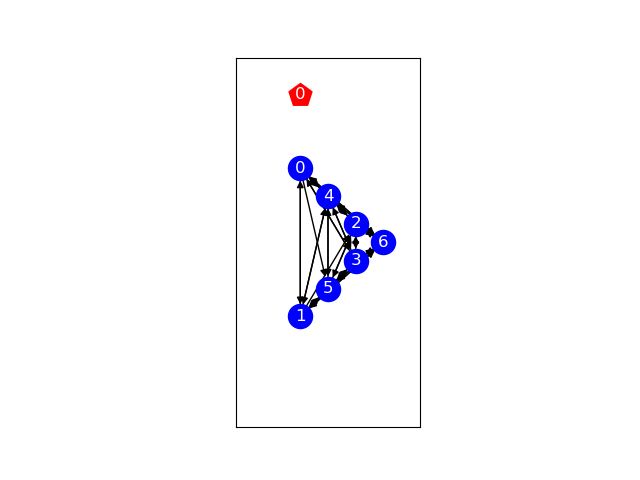

simulation time:  0
simulation time:  1
simulation time:  2
simulation time:  3
simulation time:  4
simulation time:  5
simulation time:  6
simulation time:  7
simulation time:  8
simulation time:  9
simulation time:  10
simulation time:  11
simulation time:  12
simulation time:  13
simulation time:  14
simulation time:  15
simulation time:  16
simulation time:  17
simulation time:  18
simulation time:  19
simulation time:  20
simulation time:  21
simulation time:  22
simulation time:  23
simulation time:  24
simulation time:  25
simulation time:  26
simulation time:  27
simulation time:  28
simulation time:  29
simulation time:  30
simulation time:  31
simulation time:  32
simulation time:  33
simulation time:  34
simulation time:  35
simulation time:  36
simulation time:  37
simulation time:  38
simulation time:  39
simulation time:  40
simulation time:  41
simulation time:  42
simulation time:  43
simulation time:  44
simulation time:  45
simulation time:  46
simulation time:  47
si

/home/behzad/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/behzad/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


 263
simulation time:  264
simulation time:  265
simulation time:  266
simulation time:  267
simulation time:  268
simulation time:  269
simulation time:  270
simulation time:  271
simulation time:  272
simulation time:  273
simulation time:  274
simulation time:  275
simulation time:  276
simulation time:  277
simulation time:  278
simulation time:  279
simulation time:  280
simulation time:  281
simulation time:  282
simulation time:  283
simulation time:  284
simulation time:  285
simulation time:  286
simulation time:  287
simulation time:  288
simulation time:  289
simulation time:  290
simulation time:  291
simulation time:  292
simulation time:  293
simulation time:  294
simulation time:  295
simulation time:  296
simulation time:  297
simulation time:  298
simulation time:  299
simulation time:  300
simulation time:  301
simulation time:  302
simulation time:  303
simulation time:  304
simulation time:  305
simulation time:  306
simulation time:  307
simulation time:  308
simul

In [8]:
# experiment including power control for all of the blue network nodes
# TODO 1: at the moment only a simple experiment needs a lot of change to create the scenario mentioned before

sim_duration = 500
# the size estimation max iteration
T_size = 20
# power change rates  new = before * rate 
rate_dec = .8 #.8 
rate_inc = 1 #1.01

dt =.1

#number of blue agents
num_blue = 7


# Scenario initialisation using networkx
# creating a connected blue graph topology and a sparse (not neccessarily connected) red graph near it but not inside it 

# random_seed = np.random.random()
# print (random_seed)

# # random_seed  = 0.25152749622173254

# enemy nodes as a separate graph
# G_red = nx.fast_gnp_random_graph(1, .5, seed=random_seed, directed=False)
G_red = nx.empty_graph(1)



# center of blue graph
center_blue = (5.0,0.0)

# G_blue = nx.fast_gnp_random_graph(num_blue, 1, directed=True)
G_blue = nx.fast_gnp_random_graph(num_blue, .4, directed=True)
while (nx.is_strongly_connected(G_blue) == False):
    G_blue = nx.fast_gnp_random_graph(num_blue, .4, directed=True)
    print ("changed the initial graph")

    
scale_x = 20
scale_y = 20

# pos_red = np.array([[2.0, 16], [2.0, -16.0]])
pos_red = np.array([[2.0, 16]])
pos_blue = np.array([[2.0, 8.0],[2.0,-8.0],[8.0,2.0],[8.0,-2.0],[5.0,5.0],[5.0,-5.0],[11.0, 0.0]])


for i in G_blue.nodes:
    dis = 0
    for j in G_blue.successors(i):
        dis = np.maximum(dis, np.linalg.norm(pos_blue[i] - pos_blue[j])**2 )
    
    for k in G_blue.nodes:
        if (k != i and k not in G_blue.successors(i)):
            if (np.linalg.norm(pos_blue[i] - pos_blue[k])**2 <= dis):
                G_blue.add_edge(i,k)

rate_move = .6

safe_dist = .1

# Movement parameters
theta = np.pi/6
velocity = 12


fig, axi = plt.subplots()
axi.axis([-5,15,
          -20,20])
axi.set_aspect('equal')
nx.draw_networkx(G_red,pos_red,node_shape="p",font_color='white', node_color='red',ax=axi)
nx.draw_networkx(G_blue,pos_blue,node_color='blue',font_color='white',ax=axi)

# G_blue, pos_blue, G_red, pos_red, radio_power_all, center_blue, scale_blue,offset, T_size,
#                  rate_dec, rate_inc, rate_move, safe_dist, theta, velocity, dt)
Sim = Simulation(G_blue, pos_blue,G_red, pos_red, topo2power (G_blue, pos_blue),
                 center_blue,scale_x, scale_y, T_size, rate_dec, rate_inc, rate_move, safe_dist, theta, velocity, dt)

for i in range(sim_duration):
    Sim.simulation_step()
    
# time.sleep(5)
        
    



In [9]:
#this script plots the correct final chopped graph calculated in a centralised way

# calculate the weight of each existing edge as the ratio of distance between agents divided by
# the distance from emitter to enemy

def greedy_cul(G_blue, pos_blue, pos_red):
    
    G  = G_blue.copy()

    for i in G_blue.nodes():
        for j in G_blue.successors(i):


                G[i][j]['weight'] = np.linalg.norm(pos_blue[i]-pos_blue[j])**2/np.linalg.norm(pos_blue[i]-
                                                                                           pos_red)**2



    # sort the edges based on highest weight and delete if does not make the network not strongly connected
    G_final = G.copy()
    failed_nodes = []

    for a, b, data in sorted(G.edges(data=True), key=lambda x: -x[2]['weight']):
        if a not in failed_nodes: 
            G_temp = G_final.copy()
            G_temp.remove_edge(a,b)

            if nx.is_strongly_connected(G_temp):
    #             print (" edge {0}{1} removed".format(a,b))
                G_final = G_temp.copy()
            else:
    #             print ("failed to delete edge {0}{1} ".format(a,b))
    #             print ("{} excluded from further cutting".format(a))
                failed_nodes.append(a)

    G_final.edges(data=False)        

    # print (G_final.edges )   
    # print ("edges cutted", set(G.edges)-set(G_final.edges))


    # fig, axi = plt.subplots()
    # axi.axis([center_blue[0]-scale_blue - offset -1,center_blue[0] + scale_blue + offset + 1,
    #           center_blue[1]-scale_blue - offset -1,center_blue[1] + scale_blue+ offset + 1])
    # axi.set_aspect('equal')
    # nx.draw_networkx(G_red,[model_data.at[0,"Pos_Red"]],node_shape="p",font_color='white', node_color='red',ax=axi)
    # nx.draw_networkx(G_final,pos_blue,node_color='blue',font_color='white',ax=axi)    

    G_l_sorted_greedy = sorted(G_final.edges(data=True), key=lambda item: -item[2]['weight'])

    
    return G_final, G_l_sorted_greedy[0][2]['weight']

    

    
    
    # print ("min sup G edges", G_l_sorted_greedy)




# print ("\n", G_final.edges.data())    

# # # Sim.visualise_communications().save('./DPCanimation.gif', writer='imagemagick', fps=60)
# print ([i for i in G_blue.successors(3)])
# print ([np.linalg.norm(pos_blue[3]-pos_blue[i]) for i in G_blue.successors(3)])


In [10]:
import itertools
import operator

def product_2(*args):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = map(tuple, args) #* kwds.get('repeat', 1)
    result = [[]]
    for pool in pools:
        result = [x+y for x in result for y in pool]
    for prod in result:
        yield prod

A = [[(1,2),(1,3)],[(1,3)]]
B = [[(0,1),(0,3)],[(0,3)]]
di = {}
di[0]=A
di[1]=B
list_edgesets = product_2(*[di[i] for i in range(2)]
                         )
list_edgesets = list(list_edgesets)
# print (list_edgesets)

In [11]:
from itertools import combinations, product

def sup_RSS_G (G, pos_blue, pos_red):
    """
    This method calculates a python dictionary of strongly connected culled versions of a given strongly connected digraph 
    and their associated maximum RSS at pos_red coordinates, sorted from least sup RSS up.
    inputs: 
    G       : strongly connected initial graph
    pos_blue : array of x,y array coordinates of blue nodes
    pos_red : array of x.y coordinates of red node
    
    
    
    output: 
    
    G_list        : Dict of strongly connected versions of G and their Sup RSS sorted from least sup RSS down (
                            G_l_sorted[0][1] is min SUP RSS while G_l_sorted[0][0] is the graph associated with that)
        
    """

    G_list = []
    if (not nx.is_strongly_connected(G)):
        print ("ERR: graph not strongly connected")
        
    """
    New implementation Start
     is more efficient by not considering the combinations that are redundant or not practical with respect
     to the transmission power based model of the graph.
    """
    G_temp_b = G.copy()
    
    for i in G.nodes():
        for j in G.successors(i):

            G_temp_b[i][j]['weight'] = np.linalg.norm(pos_blue[i]-pos_blue[j])**2
    
    edges = {}
    for i in G.nodes():
        
        edges[i] = []
        
        for j in G.successors(i):
            
            ij_edges = []
            ij_edges.append((i,j))
            
            for k in G.successors(i):
                
                if (k!=j and G_temp_b[i][j]['weight'] >= G_temp_b[i][k]['weight']):
                    ij_edges.append((i,k))
                    
            edges[i].append(ij_edges)
#     print (edges[0])        
    list_edgesets = product_2(*[edges[i] for i in G.nodes()])
    list_edgesets = list(list_edgesets)
#     print (list_edgesets)
            
    """
    New implementation End
      
    """
        
#     if nx.is_strongly_connected(G):
        
#         m = 0
        
#         for (i,j) in G.edges():
#             weight = np.linalg.norm(pos_blue[i]-pos_blue[j])/np.linalg.norm(pos_blue[i]- pos_red)
#             if weight > m:
#                 m = weight
            
#         G_list.append((G, m))
   
    
#     list_edgesets = []
#     for i in range(len(G.edges())-1,len(G.nodes())-1,-1):
        
#         list_edgesets.extend(combinations(G.edges(), i))
    
    for es in list_edgesets:
        G_temp = nx.DiGraph()
        G_temp.add_nodes_from(G)
        G_temp.add_edges_from(es)
        

        if nx.is_strongly_connected(G_temp):
            m = 0
            for (i,j) in es:
                weight = np.linalg.norm(pos_blue[i]-pos_blue[j])**2/np.linalg.norm(pos_blue[i]- pos_red)**2
                if weight > m:
                    m = weight
            G_list.append((G_temp.copy(), m))
            
            
    G_l_sorted = sorted(G_list, key=lambda item: item[1]) 
       
        
    return G_l_sorted

def show_net (G_blue, G_red, pos_blue, pos_red):
    
    fig, axi = plt.subplots()
    axi.axis([-5,20, -20,20])
    axi.set_aspect('equal')
    nx.draw_networkx(G_red,pos_red,node_shape="p",font_color='white', node_color='red',ax=axi)
    nx.draw_networkx(G_blue,pos_blue,node_color='blue',font_color='white',ax=axi)

#number of blue agents
# num_blue = 7


# Scenario initialisation using networkx
# creating a connected blue graph topology and a sparse (not neccessarily connected) red graph near it but not inside it 

# random_seed = np.random.random()
# print (random_seed)

# # random_seed  = 0.25152749622173254

# enemy nodes as a separate graph
# G_red = nx.fast_gnp_random_graph(1, .5, seed=random_seed, directed=False)
G_red = nx.empty_graph(2)



# # center of blue graph
# center_blue = (5.0,0.0)

# G_blue = nx.fast_gnp_random_graph(num_blue, .4, directed=True)
# while (nx.is_strongly_connected(G_blue) == False):
#     G_blue = nx.fast_gnp_random_graph(num_blue, .4, directed=True)
# #     G_blue = nx.binomial_graph(num_blue, .6, seed=random_seed, directed=True)
#     print ("changed the initial graph")


# scale_x = 20
# scale_y = 20

# pos_red = np.array([[-2.0, 8.0], [2.0, -16.0]])
# # pos_blue = np.array([[2.0, 8.0],[2.0,-8.0],[8.0,2.0],[8.0,-2.0]])
# pos_blue = np.array([[2.0, 7.0],[2.0,-8.0],[15.0,4.0],[13.0,-2.0],[0.0,-5.0],[9.0,-5.0],[15.0, 10.0]])


# for i in G_blue.nodes:
#     dis = 0
#     for j in G_blue.successors(i):
#         dis = np.maximum(dis, np.linalg.norm(pos_blue[i] - pos_blue[j]) )
    
#     for k in G_blue.nodes:
#         if (k != i and k not in G_blue.successors(i)):
#             if (np.linalg.norm(pos_blue[i] - pos_blue[k]) <= dis):
#                 G_blue.add_edge(i,k)
                
                
G  = G_blue.copy()
# # for i in G_blue.nodes():
# #         for j in G_blue.successors(i):

# #             G[i][j]['weight'] = np.linalg.norm(pos_blue[i]-pos_blue[j])/np.linalg.norm(pos_blue[i]-
# #                                                                                        pos_red)

# # G_list.append(G)
# print ("number of edges = ", len(G.edges())) 
# show_net(G, G_red, pos_blue, pos_red)



G_l = sup_RSS_G (G, pos_blue, pos_red[0])

# print ("final list len: ", len(G_l))
# G_l_sorted = sorted(G_l, key=lambda item: item[1])



print  ("min sup G edges and sup", G_l[0][1] )
# show_net (G_l[0][0], G_red, pos_blue, pos_red)

G_final, greedy_sup = greedy_cul(G, pos_blue, pos_red[0])
print  ("Greedy min sup G edges and sup", greedy_sup  )
# show_net (G_final, G_red, pos_blue, pos_red)
# print ("min sup G edges", G_l_sorted[0][0].edges())


min sup G edges and sup 0.28124999999999994
Greedy min sup G edges and sup 0.28124999999999994


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


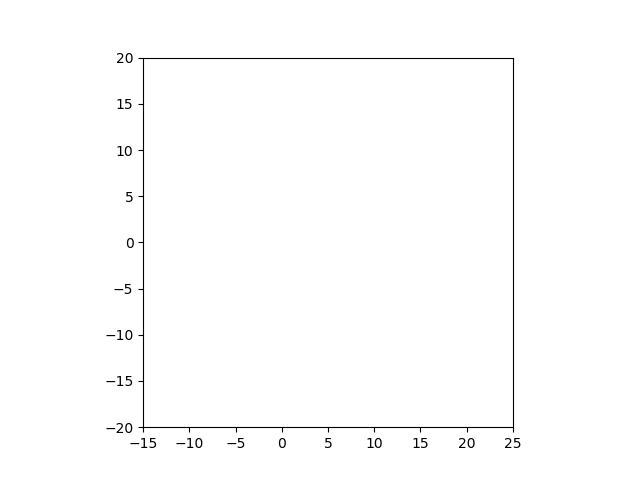

IndexError: index 1 is out of bounds for axis 0 with size 1

In [13]:
# Sim.visual_analysis()
# 1- from model we logged the red positions pos_red 
model_data = Sim.datacollector.get_model_vars_dataframe()
# print (model_data.head())
# model_power = model_data.Cent_Powers
agents_connection = model_data.Topology_Connected
agents_proposed_connection = model_data.Topology_Proposed_Connected

graph_density = model_data.Density
signature_1 = [model_data.Joint_Signature[t][0] for t in range(len(model_data))]
# signature_2 = [model_data.Joint_Signature[t][1] for t in range(len(model_data))]
# model_connection = model_data.Cent_Topology_Connected

# 2 -from agents data extract power levels
agent_data = Sim.datacollector.get_agent_vars_dataframe()
# agent_power_data = agent_data["Power"]
# agent_data = agent_data
# colors = ['b','g','r','c','m','y']
fig, axi = plt.subplots()
for i in range(len(pos_blue)):

    agent_power = agent_data.xs(i, level="AgentID")["Power"]
    plt.plot (agent_power, label= "agent ID = {}".format(i))
    
#     agent_cent_power = [model_data.iloc[t,4][i] for t in range (len(model_data))]
#     plt.plot (agent_cent_power,color = colors[i], linestyle = '--', label= "centralised agent ID = {}".format(i))
    

    
plt.legend()
plt.xlabel('simulation time',fontsize=10)
plt.ylabel('Tx Power',fontsize=10)
plt.title('Tx Power of all agents vs Time',fontsize=10)
# plt.show()
fig, axi = plt.subplots()
for i in range(len(pos_blue)):

    agent_lead = agent_data.xs(i, level = "AgentID")["Lead"]
    plt.plot (agent_lead, label= "agent ID = {}".format(i))
    
#     agent_cent_power = [model_data.iloc[t,4][i] for t in range (len(model_data))]
#     plt.plot (agent_cent_power,color = colors[i], linestyle = '--', label= "centralised agent ID = {}".format(i))
    

    
plt.legend()
plt.xlabel('simulation time',fontsize=10)
plt.ylabel('Leader',fontsize=10)
plt.title('Leader status of all agents vs Time',fontsize=10)
# plt.show()

fig, axi = plt.subplots()
# plt.plot (model_connection, label= "centralised connectedness status") 
plt.plot (agents_connection, label= "agents connectedness status") 
plt.plot (agents_proposed_connection, label= "agents proposed connectedness status") 

plt.legend()
plt.xlabel('simulation time',fontsize=10)
plt.ylabel('connectedness status',fontsize=10)
plt.title('connectedness status of centralised and distributed approaches vs Time',fontsize=10)
# plot the BT mode of agets

fig, axi = plt.subplots()
# plt.plot (model_connection, label= "centralised connectedness status") 
plt.plot (graph_density) 
plt.xlabel('Simulation Time Step',fontsize=10)
plt.ylabel('Graph Density',fontsize=10)
plt.title('Graph Density vs Time',fontsize=10)
plt.savefig('Density.pdf',bbox_inches='tight')

fig, axi = plt.subplots()
plt.plot (signature_1, label = 'distributed' )
# plt.plot (signature_2, label = 'Agent 1' )
plt.axhline(y=G_l[0][1], color='r', linestyle='-.', label='optimal')
plt.axhline(y=greedy_sup, color = 'k', linestyle=':', label='greedy')

plt.xlabel('Simulation Time Step',fontsize=10)
plt.ylabel('Effective RSS at Eavesdropper Agent',fontsize=10)
plt.title('Effective RSS  vs Time',fontsize=10)
plt.legend()
plt.savefig('RSS.pdf',bbox_inches='tight')



# plot the BT mode of agets
iterations = len(model_data)

fig, axi = plt.subplots()
axi.axis([model_data.at[0,"Center_Blue"][0]-scale_x,model_data.at[0,"Center_Blue"][0] + scale_x,
          model_data.at[0,"Center_Blue"][1]-scale_y,model_data.at[0,"Center_Blue"][1] + scale_y])
axi.set_aspect('equal')
nx.draw_networkx(G_red,model_data.at[0,"Pos_Red"],node_shape="p",font_color='white', node_color='red',ax=axi)
nx.draw_networkx(model_data.at[0,"Blue_Topology"],model_data.at[0,"Pos_Blue"],node_color='blue',font_color='white',ax=axi)
plt.xlabel('x Coordinate',fontsize=10)
plt.ylabel('y Coordinate',fontsize=10)
plt.title('Scenario Configuration at t=0 s \n network density={}'.format(model_data.at[0,"Blue_Topology"].size()),fontsize=10)
plt.savefig('Config{}.pdf'.format(0),bbox_inches='tight')

fig, axi = plt.subplots()
axi.axis([model_data.at[int((iterations-1)/4),"Center_Blue"][0]-scale_x,model_data.at[int((iterations-1)/4),"Center_Blue"][0] + scale_x,
          model_data.at[int((iterations-1)/4),"Center_Blue"][1]-scale_y,model_data.at[int((iterations-1)/4),"Center_Blue"][1] + scale_y])
axi.set_aspect('equal')
nx.draw_networkx(G_red,model_data.at[int((iterations-1)/4),"Pos_Red"],node_shape="p",font_color='white',
                             node_color='red',ax=axi)
nx.draw_networkx(model_data.at[int((iterations-1)/4),"Blue_Topology"],model_data.at[int((iterations-1)/4),"Pos_Blue"],node_color='blue',font_color='white',ax=axi)
plt.xlabel('x Coordinate',fontsize=10)
plt.ylabel('y Coordinate',fontsize=10)
plt.title('Scenario Configuration at t={0} s \n network density={1}'.format(int((dt*(iterations)/4)), 
                                                                    model_data.at[int(iterations/4),"Blue_Topology"].size()),fontsize=10)
plt.savefig('Config{}.pdf'.format(int((dt*(iterations)/4))),bbox_inches='tight')

fig, axi = plt.subplots()
axi.axis([model_data.at[int((iterations-1)/2),"Center_Blue"][0]-scale_x,model_data.at[int((iterations-1)/2),"Center_Blue"][0] + scale_x,
          model_data.at[int((iterations-1)/2),"Center_Blue"][1]-scale_y,model_data.at[int((iterations-1)/2),"Center_Blue"][1] + scale_y])
axi.set_aspect('equal')
nx.draw_networkx(G_red,model_data.at[int((iterations-1)/2),"Pos_Red"],node_shape="p",font_color='white',
                             node_color='red',ax=axi)
nx.draw_networkx(model_data.at[int((iterations-1)/2),"Blue_Topology"],model_data.at[int((iterations-1)/2),"Pos_Blue"],node_color='blue',font_color='white',ax=axi)
plt.xlabel('x Coordinate',fontsize=10)
plt.ylabel('y Coordinate',fontsize=10)
plt.title('Scenario Configuration at t={0} s \n network density={1}'.format(int((dt*(iterations)/2)), 
                                                                    model_data.at[int(iterations/2),"Blue_Topology"].size()),fontsize=10)

plt.savefig('Config{}.pdf'.format(int((dt*(iterations)/2))),bbox_inches='tight')

fig, axi = plt.subplots()
axi.axis([model_data.at[iterations-1,"Center_Blue"][0]-scale_x,model_data.at[iterations-1,"Center_Blue"][0] + scale_x,
          model_data.at[iterations-1,"Center_Blue"][1]-scale_y,model_data.at[iterations-1,"Center_Blue"][1] + scale_y])
axi.set_aspect('equal')
nx.draw_networkx(G_red,model_data.at[iterations-1,"Pos_Red"],node_shape="p",font_color='white',
                             node_color='red',ax=axi)
nx.draw_networkx(model_data.at[iterations-1,"Blue_Topology"],model_data.at[iterations-1,"Pos_Blue"],node_color='blue',font_color='white',ax=axi)
plt.xlabel('x Coordinate',fontsize=10)
plt.ylabel('y Coordinate',fontsize=10)
plt.title('Scenario Configuration at t={0} s \n network density={1}'.format(int((dt*(iterations))), 
                                                                    model_data.at[iterations-1,"Blue_Topology"].size()),fontsize=10)

plt.savefig('Config{}.pdf'.format(int((dt*(iterations)))),bbox_inches='tight')
#plt.savefig('name.pdf',bbox_inches='tight')
# pri+nt (np.shape (pos_red[:,1][0]))

# print ("model_data.at[1,Pos_Red]", model_data.at[1,"Pos_Red"], "model_data.at[300,Pos_Red]", model_data.at[300,"Pos_Red"] )



blue_x = [model_data.at[k,"Pos_Blue"][5][0] for k in range(iterations)]
blue_y = [model_data.at[k,"Pos_Blue"][5][1] for k in range(iterations)]


fig, axi = plt.subplots()
for i in range(len(pos_red)):
    red_x = [model_data.at[k,"Pos_Red"][i][0] for k in range(iterations)]
    red_y = [model_data.at[k,"Pos_Red"][i][1] for k in range(iterations)]
    plt.plot (red_x,red_y)
plt.plot (blue_x,blue_y)
nx.draw_networkx(G_red,model_data.at[0,"Pos_Red"],node_shape="p",font_color='white', node_color='red',ax=axi)
nx.draw_networkx(model_data.at[0,"Blue_Topology"],model_data.at[0,"Pos_Blue"],node_color='blue',font_color='white',ax=axi)


plt.xlabel('simulation time',fontsize=10)
plt.ylabel('Red movement x,y ',fontsize=10)
plt.title('Red movement  against the original setup',fontsize=10)



In [ ]:
plt.rcParams['animation.embed_limit'] = 2**128

# running the simulation
Sim.animate_network()


In [ ]:
# # test of power to and from topology conversion methods


# # a power to topology method test
# print ("G_blue.edges ",G_blue.edges)

# #test 
# for i in G_blue.nodes:
#     dis = 0
#     for j in G_blue.successors(i):
#         dis = np.maximum(dis, np.linalg.norm(pos_blue[i] - pos_blue[j]) )
    
#     for k in G_blue.nodes:
#         if (k != i and k not in G_blue.successors(i)):
#             if (np.linalg.norm(pos_blue[i] - pos_blue[k]) <= dis):
#                 print ("node {0} should have been a successor of node {1}".format(k,i))
 

# G_blue_test = power2topo(topo2power (G_blue, pos_blue),pos_blue)
# print ("G_blue_test.edges ",G_blue_test.edges)
# fig, axi = plt.subplots()
# axi.axis([center_blue[0]-scale_blue - offset -1,center_blue[0] + scale_blue + offset + 1,
#           center_blue[1]-scale_blue - offset -1,center_blue[1] + scale_blue+ offset + 1])
# axi.set_aspect('equal')
# nx.draw_networkx(G_blue_test,pos_blue,node_color='blue',font_color='white',ax=axi)


# # fig, axi = plt.subplots()
# # axi.axis([center_blue[0]-scale_blue - offset -1,center_blue[0] + scale_blue + offset + 1,
# #           center_blue[1]-scale_blue - offset -1,center_blue[1] + scale_blue+ offset + 1])
# # axi.set_aspect('equal')
# # nx.draw_networkx(G_blue,pos_blue,node_color='blue',font_color='white',ax=axi)












# # #number of agents
# # num_agents = np.shape(G_blue)[0]

# # # initial power of all blue vehicles is zero
# # radio_power_all = np.zeros(num_agents)
# # # 0 * np.random.rand(num_agents)
# # for a in G_blue:
    

# # #     f = farthest_neigh(pos_blue[a], G_blue.successors(a), pos_blue)
     
# #     radio_power_all[a] = np.max ([
# #                         np.linalg.norm(pos_blue[a] - pos_blue[k])**2   
# #                         for k in G_blue.successors(a)])
# # #     np.linalg.norm(pos_blue[a]-pos_blue[f])**2 
            


# fig, axi = plt.subplots()
# axi.axis([center_blue[0]-scale_blue - offset -1,center_blue[0] + scale_blue + offset + 1,
#           center_blue[1]-scale_blue - offset -1,center_blue[1] + scale_blue+ offset + 1])
# axi.set_aspect('equal')
# nx.draw_networkx(G_red,[pos_red],node_shape="p",font_color='white', node_color='red',ax=axi)
# nx.draw_networkx(G_blue,pos_blue,node_color='blue',font_color='white',ax=axi)

In [ ]:

print (model_data.at[0,"Pos_Blue"], "\n\n new one \n\n", model_data.at[400,"Pos_Blue"])

print ("red \n\n", model_data.at[0,"Pos_Red"], "\n\n new one \n\n", model_data.at[400,"Pos_Red"])

print ("center \n\n", model_data.at[0,"Center_Blue"], "\n\n new one \n\n", model_data.at[400,"Center_Blue"])


In [ ]:
# # experiment including power control for all of the blue network nodes
# # TODO 1: at the moment only a simple experiment needs a lot of change to create the scenario mentioned before

# sim_duration = 500
# # the size estimation max iteration
# T_size = 20
# # power change rates  new = before * rate 
# rate_dec = .7 
# rate_inc = 1.001

# dt =.1

# #number of blue agents
# num_blue = 6


# # Scenario initialisation using networkx
# # creating a connected blue graph topology and a sparse (not neccessarily connected) red graph near it but not inside it 

# random_seed = np.random.random()
# print (random_seed)

# # random_seed  = 0.25152749622173254

# # enemy nodes as a separate graph
# G_red = nx.fast_gnp_random_graph(1, .5, seed=random_seed, directed=False)

# # # random positions in a unit circle centered at indicated
# # pos_red = nx.spring_layout(G_red, center=(2,2),  random_state=None)



# # center of blue graph
# center_blue = (1.0,1.0)


# # blue nodes as a separate graph
# # G_blue = nx.binomial_graph(6, .5, seed=random_seed, directed=True)
# G_blue = nx.fast_gnp_random_graph(num_blue, .6, seed = None, directed = True)
# while (nx.is_strongly_connected(G_blue) == False):
#     G_blue = nx.binomial_graph(num_blue, .6, seed=random_seed, directed=True)
#     print ("changed the initial graph")
# # G_blue = nx.DiGraph()
# # G_blue.add_nodes_from(range(5))


# #nx.connected_watts_strogatz_graph(6, 2, .7, tries=100, seed=None)
# # positions based on spring layout
# scale_blue = 10
# pos_blue_1=nx.spring_layout(G_blue, center = center_blue, scale=scale_blue)

# pos_blue = np.array([pos_blue_1[i] for i in range(len(pos_blue_1))])

# for i in G_blue.nodes:
#     dis = 0
#     for j in G_blue.successors(i):
#         dis = np.maximum(dis, np.linalg.norm(pos_blue[i] - pos_blue[j]) )
    
#     for k in G_blue.nodes:
#         if (k != i and k not in G_blue.successors(i)):
#             if (np.linalg.norm(pos_blue[i] - pos_blue[k]) <= dis):
#                 G_blue.add_edge(i,k)
# # print ("topo edges: ", G_blue.edges)

# # pos red  vehicle
# offset = 7
# pos_red = np.array([[center_blue[0]-scale_blue - offset, center_blue[1] + scale_blue + offset]])


# rate_move = .6

# safe_dist = .1

# # Movement parameters
# theta = np.pi/6
# velocity = 10


# fig, axi = plt.subplots()
# axi.axis([center_blue[0]-scale_blue - offset -1,center_blue[0] + scale_blue + offset + 1,
#           center_blue[1]-scale_blue - offset -1,center_blue[1] + scale_blue+ offset + 1])
# axi.set_aspect('equal')
# nx.draw_networkx(G_red,pos_red,node_shape="p",font_color='white', node_color='red',ax=axi)
# nx.draw_networkx(G_blue,pos_blue,node_color='blue',font_color='white',ax=axi)

# # G_blue, pos_blue, G_red, pos_red, radio_power_all, center_blue, scale_blue,offset, T_size,
# #                  rate_dec, rate_inc, rate_move, safe_dist, theta, velocity, dt)
# Sim = Simulation(G_blue, pos_blue,G_red, pos_red, topo2power (G_blue, pos_blue),
#                  center_blue,scale_blue,offset, T_size, rate_dec, rate_inc, rate_move, safe_dist, theta, velocity, dt)

# for i in range(sim_duration):
#     Sim.simulation_step()
    
# # time.sleep(5)
        
    



In [ ]:
# # this method calculates signature or power recieved rp from an agent with transmission power tp located at l_i with respect to enemy location l_e
# def signature(tp, l_i, l_e):
    
#     rp = tp/np.linalg.norm(l_i,l_e)**2 
    
#     return rp

In [ ]:
# # Assuming that pos_blue is a strongly connected directed graph, this method calculates longest distance successor index
# # of the agent located at l_i as compared to position of successors pos_blue[n]
# def farthest_neigh(l_i, successors, pos_blue):
     
#     index = 0
#     max_dist = 0
    
#     for n in successors:
        
#         dist = np.linalg.norm(l_i-pos_blue[n])
#         if dist > max_dist :
#             max_dist = dist
#             index = n
#     return index

# print (farthest_neigh(np.array([0,0]), np.array([1,2]), np.array([[0,0],[3,2],[5,2]])) )

In [ ]:
# # uniform weighting (chose the same weight for self and successors such that their sum=1)
# def out_weights(unique_id, topology_blue):
    
    
    
#     # number of successors of id
#     num_successors = 0 
    
#     for i in topology_blue.successors(unique_id):
#         num_successors = num_successors + 1 
    
#     # number of enteries in one column of weighting matrix (accounting for self weight) 
#     total_num = num_successors + 1
    
#     p = 1/total_num
    
    
#     return p 

In [ ]:
# def position_control (i, center_blue, pos_blue, pos_red, movement_factor, safe_dist):
    
#     position_old = pos_blue[i]
#     position = position_old + movement_factor * (center_blue - pos_red)/(np.dot(center_blue- pos_red,
#                                                                             center_blue- pos_red)**.5) 
#     for j in [k for k in range(len(pos_blue)) if k!= i]:
#               if (np.dot(position-pos_blue[j], position-pos_blue[j])**.5 < safe_dist):
#                   position = position_old
#                   break
                
              
    
#     return position